# Word 2 vec with trained data (n=300)

## Imports and load data

In [1]:
## for data
import pandas as pd
import numpy as np#

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers
import simpletransformers

In [2]:
### load labeled data

data = pd.read_csv('../raw_data/adr_labelled_data.csv', nrows=300)

#data = data[data['rating'] < 5]
#data["sideEffect"] = data["sideEffect"].astype(int)
data = data.reset_index(drop = True)
data = data.sort_values(by=['drugName'])
data = data.reset_index(drop = True)
data = data.drop(["uniqueID", "date", "usefulCount"], axis = 1)
# print(pd.DataFrame(data["drugName"].value_counts()))

data.tail()

,drugName,condition,review,rating,sideEffect
295,Zanaflex,Muscle Spasm,"""I have been taking Zanaflex for about a year ...",10,0.0
296,Ziana,Acne,"""I had a wonderful experience with Ziana. This...",10,0.0
297,Zoledronic acid,Osteolytic Bone Metastases of Solid Tumors,"""I dreaded the side-effects and had NONE. I h...",10,0.0
298,Zoloft,Panic Disorde,"""Been taking Zoloft for 2 weeks and 3 days for...",9,0.0
299,Zomig,Migraine,"""Zomig gets rid of my migraine but it knocks m...",7,1.0


In [3]:
data = data.dropna()
data.isnull().sum()

drugName      0
condition     0
review        0
rating        0
sideEffect    0
dtype: int64

In [4]:
data["review"][4]

'"This med helps to take the edge off enough for the pain to be tolerable. I take HCL 15 mg one every 6 hours. Compared to hydrocodone this is much better and faster relief. Just be careful what you take with it."'

## Preprocessing

In [5]:
### define preprocessing utlities function

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
### download stopwords

lst_stopwords = nltk.corpus.stopwords.words("english")

In [7]:
### creat cleaned text column

data["review_clean"] = data["review"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.tail()

,drugName,condition,review,rating,sideEffect,review_clean
295,Zanaflex,Muscle Spasm,"""I have been taking Zanaflex for about a year ...",10,0.0,taking zanaflex year wonderful ankylosing spon...
296,Ziana,Acne,"""I had a wonderful experience with Ziana. This...",10,0.0,wonderful experience ziana acne medication did...
297,Zoledronic acid,Osteolytic Bone Metastases of Solid Tumors,"""I dreaded the side-effects and had NONE. I h...",10,0.0,dreaded sideeffects none intravenous infusion ...
298,Zoloft,Panic Disorde,"""Been taking Zoloft for 2 weeks and 3 days for...",9,0.0,taking zoloft 2 week 3 day panic attack genera...
299,Zomig,Migraine,"""Zomig gets rid of my migraine but it knocks m...",7,1.0,zomig get rid migraine knock take one dose sle...


In [8]:
data["sideEffect"] = data["sideEffect"].astype(int)
data["sideEffect"]


0      1
1      1
2      0
3      1
4      0
      ..
295    0
296    0
297    0
298    0
299    1
Name: sideEffect, Length: 297, dtype: int64


## Word 2 Vec - word embedding

### tranform into list of n-grams

In [9]:
corpus = data["review_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
                              delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [10]:
### read in and x_train y_train
x_train = data[["review_clean"]]
y_train = data["sideEffect"]


In [11]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [12]:
word = "nausea"
nlp[word].shape

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


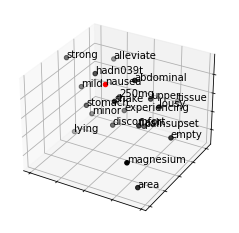

In [26]:
### visual word in x dimensional space

word = "nausea"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### tokenize and pad text

In [27]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [ ]:
X_train

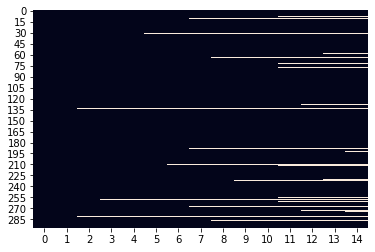

In [28]:
### feature matrix

sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [29]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(data["review_clean"].iloc[i].split())
print("from: ", data["review_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", data["review_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[data["review_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  15 year old freshman high school broke severe acne literally one week skin went perfectly clear large acne blotch cheek chin neck painful touch trying everything arsenal time monocycline benzaclin finacea etc dermatologist recommended accutane side effect ridiculously chapped lip dry skin face joint pain month half treatment acne gone completely skin clearer everyday thereafter depressed acne medicine changed life better never needed usetake another acne medication following 4 5 month treatment | len: 72
to:  [ 177    4   98 1377  233  304  546  109   44  340   18    3   62   36
  547] | len: 15
check:  15  -- idx in vocabulary --> 177
vocabulary:  {'NaN': 1, 'day': 2, 'week': 3, 'year': 4, 'effect': 5} ... (padding element, 0)


### create matrix of embeddings

In [30]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [31]:
word = "nausea"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 148 |idx
embeddings[idx]: (300,) |vector


## Build a bidirectional LSTM

In [33]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)## apply attention

x = attention_layer(x, neurons=15)## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)

x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)## final dense layers
x = layers.Dense(64, activation='relu')(x)

y_out = layers.Dense(1, activation='sigmoid')(x)

## compile

model = models.Model(x_in, y_out)

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      911100      input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
_______________________________________________________________________________________

In [34]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train

training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

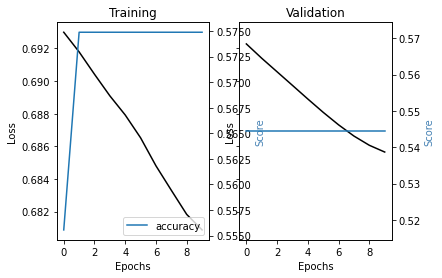

In [35]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()

ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")

plt.show()

In [36]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

NameError: name 'X_test' is not defined

# Word 2 vec with ratings as y_train

In [30]:
### load labeled data

data = pd.read_csv('../raw_data/drugsComTrain_raw.csv')

#data = data[data['rating'] < 5]
data = data.reset_index(drop = True)
data = data.sort_values(by=['drugName'])
data = data.reset_index(drop = True)
data = data.drop(["uniqueID", "date", "usefulCount"], axis = 1)

data["rating_b"] = np.where(data['rating']>=5, 1, 0)
# print(pd.DataFrame(data["drugName"].value_counts()))

data.tail()

,drugName,condition,review,rating,rating_b
161292,ella,Emergency Contraception,"""Had a small accident early hours of 18th June...",8,1
161293,ella,Emergency Contraception,"""So I took Ellaone when I wasn&rsquo;t quite s...",4,0
161294,femhrt,0</span> users found this comment helpful.,"""I was on femHRT for four months and had BV (b...",1,0
161295,femhrt,Acne,"""Recently switched from birth conrtol which ke...",1,0
161296,femhrt,Postmenopausal Symptoms,"""This medication completely changed my life fo...",10,1


In [31]:
#data = data.dropna()
data.isnull().sum()

drugName       0
condition    899
review         0
rating         0
rating_b       0
dtype: int64

## define functions

In [32]:
### define preprocessing utlities function

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [5]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [33]:
### creat cleaned text column

data["review_clean"] = data["review"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.tail()

,drugName,condition,review,rating,rating_b,review_clean
161292,ella,Emergency Contraception,"""Had a small accident early hours of 18th June...",8,1,small accident early hour 18th june took ella ...
161293,ella,Emergency Contraception,"""So I took Ellaone when I wasn&rsquo;t quite s...",4,0,took ellaone wasnrsquot quite sure done ovulat...
161294,femhrt,0</span> users found this comment helpful.,"""I was on femHRT for four months and had BV (b...",1,0,femhrt four month bv bacterial vaginitis four ...
161295,femhrt,Acne,"""Recently switched from birth conrtol which ke...",1,0,recently switched birth conrtol kept skin shap...
161296,femhrt,Postmenopausal Symptoms,"""This medication completely changed my life fo...",10,1,medication completely changed life better also...


In [34]:
corpus = data["review_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
                              delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [35]:
y_train = data["rating_b"]

In [38]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 432x288 with 0 Axes>

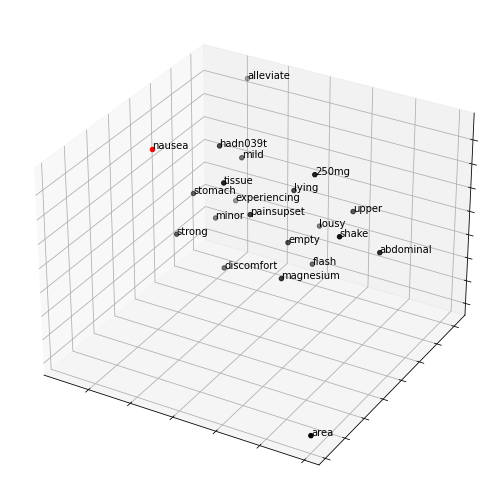

In [40]:
### visual word in x dimensional space

word = "nausea"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### tokenize and pad text

In [40]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

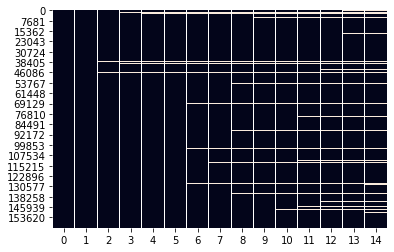

In [41]:
### feature matrix

sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [42]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(data["review_clean"].iloc[i].split())
print("from: ", data["review_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", data["review_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[data["review_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  severe cracked skin hand i039ve tried many different product skin extremely sensitive product help heal skin sting greasy important using hand best product i039ve found condition hard find drugstore can039t even order anymore | len: 33
to:  [  86 3787   96  342   13   64  131  156  247   96  216  661  247   50
 1906] | len: 15
check:  severe  -- idx in vocabulary --> 86
vocabulary:  {'NaN': 1, 'day': 2, 'month': 3, 'year': 4, 'week': 5} ... (padding element, 0)


### create feature matrix for embeddings


In [43]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [44]:
word = "nausea"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 103 |idx
embeddings[idx]: (300,) |vector


### same feature engineering for test data

In [45]:
## read in test data

data_test = pd.read_csv('../raw_data/drugsComTest_raw.csv')

#data = data[data['rating'] < 5]
data_test = data_test.reset_index(drop = True)
data_test = data_test.sort_values(by=['drugName'])
data_test = data_test.reset_index(drop = True)
data_test = data_test.drop(["uniqueID", "date", "usefulCount"], axis = 1)
data_test["rating_b"] = np.where(data_test['rating']>=5, 1, 0)

# print(pd.DataFrame(data["drugName"].value_counts()))

data_test.tail()



,drugName,condition,review,rating,rating_b
53761,ella,Emergency Contraception,"""I took Ella One approximately 8-9 hours after...",10,1
53762,femhrt,Menstrual Disorders,"""Hot flashes completely gone in less than 2 we...",10,1
53763,femhrt,Postmenopausal Symptoms,"""Femhrt worked wonderful. Had to wait a coupl...",9,1
53764,femhrt,Acne,"""femhrt took away my hot flashes within a week...",8,1
53765,pHisoHex,"Skin Disinfection, Preoperative","""Before Phisohex could only be purchased by pr...",10,1


In [46]:
### creat cleaned text column

data_test["review_clean"] = data_test["review"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

y_test = data_test["rating_b"]

data_test.tail()

,drugName,condition,review,rating,rating_b,review_clean
53761,ella,Emergency Contraception,"""I took Ella One approximately 8-9 hours after...",10,1,took ella one approximately 89 hour unprotecte...
53762,femhrt,Menstrual Disorders,"""Hot flashes completely gone in less than 2 we...",10,1,hot flash completely gone le 2 week work great
53763,femhrt,Postmenopausal Symptoms,"""Femhrt worked wonderful. Had to wait a coupl...",9,1,femhrt worked wonderful wait couple month full...
53764,femhrt,Acne,"""femhrt took away my hot flashes within a week...",8,1,femhrt took away hot flash within week acne un...
53765,pHisoHex,"Skin Disinfection, Preoperative","""Before Phisohex could only be purchased by pr...",10,1,phisohex could purchased prescription used reg...


In [47]:
corpus = data_test["review_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

## run birdirectional LTSM

In [70]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))

## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)

## apply attention
x = attention_layer(x, neurons=15)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(1, activation='sigmoid')(x)

## compile
model = models.Model(x_in, y_out)
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 15, 300)      23547300    input_7[0][0]                    
__________________________________________________________________________________________________
permute_6 (Permute)             (None, 300, 15)      0           embedding_6[0][0]                
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 300, 15)      240         permute_6[0][0]                  
______________________________________________________________________________________

Epoch 1/100
3529/3529 [==============================] - 51s 14ms/step - loss: 0.4898 - accuracy: 0.7707 - val_loss: 0.4315 - val_accuracy: 0.8110
Epoch 2/100
3529/3529 [==============================] - 41s 12ms/step - loss: 0.4645 - accuracy: 0.7853 - val_loss: 0.4227 - val_accuracy: 0.8165
Epoch 3/100
3529/3529 [==============================] - 41s 12ms/step - loss: 0.4585 - accuracy: 0.7866 - val_loss: 0.4141 - val_accuracy: 0.8192
Epoch 4/100
3529/3529 [==============================] - 40s 11ms/step - loss: 0.4522 - accuracy: 0.7907 - val_loss: 0.4087 - val_accuracy: 0.8206
Epoch 5/100
3529/3529 [==============================] - 41s 12ms/step - loss: 0.4454 - accuracy: 0.7934 - val_loss: 0.4119 - val_accuracy: 0.8218
Epoch 6/100
3529/3529 [==============================] - 42s 12ms/step - loss: 0.4395 - accuracy: 0.7960 - val_loss: 0.4043 - val_accuracy: 0.8241
Epoch 7/100
3529/3529 [==============================] - 42s 12ms/step - loss: 0.4346 - accuracy: 0.7990 - val_loss: 0

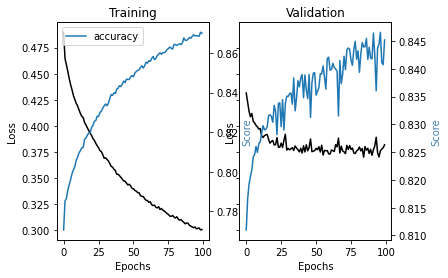

In [71]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=40, shuffle=True, verbose=1, 
                     validation_split=0.3)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')

for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')

for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")

plt.show()

In [72]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [74]:
predicted_df = pd.DataFrame(predicted)
predicted_df.tail()

,0
53761,0
53762,0
53763,0
53764,0
53765,0


In [69]:
## select observation
i = 3
txt_instance = data_test["review_clean"].iloc[i]

## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=15, 
              padding="post", truncating="post")

### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()

### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}

### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(top).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")

### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)

### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

True: 1 --> Pred: 0 | Prob: 0.93


IndexError: list index out of range